In [1]:
import tensorflow as tf
#import tensorflow.contrib.keras as keras
from pathlib import Path
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

import os
import matplotlib.pyplot as plt
import random
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt


print("Done with library declaration, Current version of Tensorflow is: ", tf.__version__)

Matplotlib is building the font cache; this may take a moment.


Done with library declaration, Current version of Tensorflow is:  2.16.1


In [8]:
class_names = ["aluminem_cans", "cardboard", "food", "generic_trash", "glass_bottle", "hazardous_waste", "medical_waste", "paper", "plastic_bottle", "plastic_not_recylable", "plastic_recylable"]

image_root_path = Path("data_organized")
train_root_path = image_root_path / "train"
test_root_path = image_root_path / "test"


os.makedirs(train_root_path, exist_ok=True)
os.makedirs(test_root_path, exist_ok=True)

train_count = 0
test_count = 0
for class_name in class_names:
    imagepath = image_root_path / class_name
    train_graypath = train_root_path / class_name
    test_graypath = test_root_path / class_name
  
    os.makedirs(train_graypath, exist_ok=True)
    os.makedirs(test_graypath, exist_ok=True)
 
    file_list = os.listdir(imagepath)
    num_files_train = int(len(file_list) * 0.8)
    num_files_test = len(file_list) - num_files_train
    test_files = random.sample(file_list, num_files_test)

    for file in file_list:
        img_path = imagepath / file
        if file in test_files:
            gray_path = test_graypath / file
            test_count += 1
        else:
            gray_path = train_graypath / file
            train_count += 1
        im = Image.open(img_path)
        img = im.resize((32, 32))
        gray = img.convert('L')
        gray.save(gray_path, "JPEG")
        
print(test_count)
print(train_count)

1970
7864


In [9]:
model = Sequential([
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(32,32, 1)),
    MaxPooling2D(pool_size=2),

    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),

    Flatten(),

    Dense(11, activation='softmax')
])



In [10]:
batch_size = 45
epochs = 60
model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 32)       │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,947 (187.29 KB)

 Trainable params: 47,947 (187.29 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
train_gen = ImageDataGenerator(rescale=1./255)
test_gen = ImageDataGenerator(rescale=1./255)


train_generator = train_gen.flow_from_directory(
    train_root_path,
    target_size=(32, 32),
    color_mode='grayscale',
    class_mode='categorical'
)

test_generator = test_gen.flow_from_directory(
    test_root_path,
    target_size=(32, 32),
    color_mode='grayscale',
    class_mode='categorical'
)


batch_size = 32
epochs = 120
steps_per_epoch = train_count // batch_size
validation_steps = test_count // batch_size





early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=7)


history = model.fit(
    train_generator,
    validation_data=test_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    # validation_steps=validation_steps
    # callbacks=[early_stopping]
)


test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy: {} Test Loss: {} '.format(test_acc*100, test_loss))







Found 9756 images belonging to 11 classes.
Found 4803 images belonging to 11 classes.
Epoch 1/120
245/245 ━━━━━━━━━━━━━━━━━━━━ 80s 312ms/step - accuracy: 0.4468 - loss: 1.8776 - val_accuracy: 0.5234 - val_loss: 1.5266
Epoch 2/120
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5274 - loss: 1.5366 - val_accuracy: 0.5297 - val_loss: 1.4969
Epoch 3/120
245/245 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step - accuracy: 0.5328 - loss: 1.4865 - val_accuracy: 0.5684 - val_loss: 1.4011
Epoch 4/120
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5556 - loss: 1.3946 - val_accuracy: 0.5632 - val_loss: 1.3819
Epoch 5/120
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.5789 - loss: 1.3262 - val_accuracy: 0.5853 - val_loss: 1.2841
Epoch 6/120
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.5793 - loss: 1.3211 - val_accuracy: 0.5984 - val_loss: 1.2541
Epoch 7/120
245/245 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - accuracy: 0.6026 - loss: 1.2594 - val_accuracy: 0.6067 - val_loss: 1.2395
E

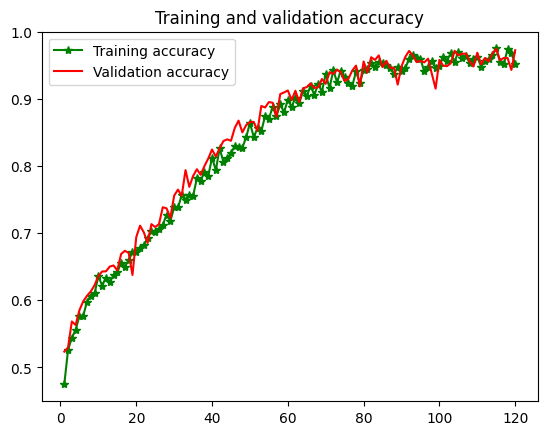

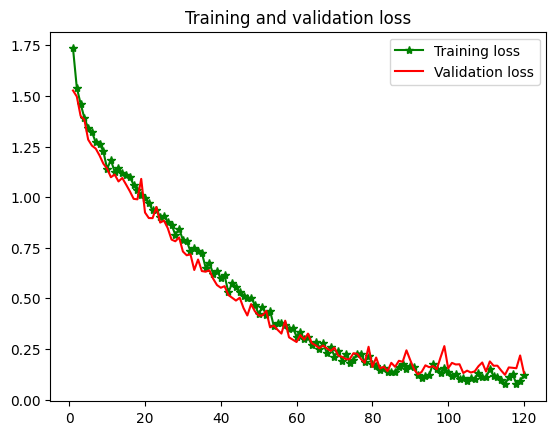

In [12]:
train_acc = history.history['accuracy'] 
val_acc = history.history['val_accuracy'] 
train_loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(1, len(train_acc) + 1)

plt.plot(epochs, train_acc, 'g*-', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_loss, 'g*-', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
# Assuming 'history' is the History object returned by the fit method
val_acc = history.history['val_accuracy']

# Calculate the average of the last 10 epochs of validation accuracy
last_10_val_acc = val_acc[-10:]
average_last_10_val_acc = np.mean(last_10_val_acc)

print(f"Average validation accuracy over the last 10 epochs: {average_last_10_val_acc:.4f}")

val_loss = history.history['val_loss']

# Calculate the average of the last 10 epochs of validation accuracy
last_10_val_loss = val_loss[-10:]
average_last_10_val_loss = np.mean(last_10_val_loss)

print(f"Average validation loss over the last 10 epochs: {average_last_10_val_loss:.4f}")

acc = history.history['accuracy']

# Calculate the average of the last 10 epochs of validation accuracy
last_10_val = acc[-10:]
average_last_10_val = np.mean(last_10_val)

print(f"Average training accuracy over the last 10 epochs: {average_last_10_val:.4f}")

val_loss = history.history['loss']

# Calculate the average of the last 10 epochs of validation accuracy
last_10_loss = val_loss[-10:]
average_last_10_loss = np.mean(last_10_loss)

print(f"Average training loss over the last 10 epochs: {average_last_10_loss:.4f}")

Average validation accuracy over the last 10 epochs: 0.9608
Average validation loss over the last 10 epochs: 0.1608
Average training accuracy over the last 10 epochs: 0.9608
Average training loss over the last 10 epochs: 0.1078
